## Import dependencies

In [153]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from CharRNN import CharRNN
import re
from string import printable,whitespace
import os

In [176]:
with open('final_dataset.txt') as file:
    text = file.read()

print(text)

PRIMER ACTO


ESCENA I

Fanfarria . Entran arriba los tribunos y los senadores; luego, abajo, por
una puerta SATURNINO y sus seguidores y por otra BASIANO y los
suyos, con tambores y estandartes .

SATURNINO: (A sus seguidores .)
Nobles patricios, protectores de mis derechos,
defiendan la verdad de mi causa con las armas;
y ustedes, compatriotas, mis amados seguidores,
aboguen por mi título de sucesión con sus espadas.
Yo soy el primogénito del último
que portó la diadema imperial de Roma;
dejen pues que el honor de mi padre viva en mí,
y no ultrajen mi mayorazgo con este agravio.

BASIANO: (A sus seguidores .)
Romanos, amigos, seguidores,
defensores de mis derechos,
si alguna vez Basiano, hijo de César,
fue visto con gracia por la real Roma,
cuiden entonces este paso al Capitolio,
y no padezcan el deshonor de acercarse
al trono imperial, consagrado a la virtud,
la justicia, la continencia, la nobleza;
dejen que el mérito brille en elección transparente,
y, romanos, peleen por su liber

Filtering chars
text_2 = re.sub(r'\n[0-9]+/[0-9]+\n\n.',r'',text)
text_2 = re.sub(r'(\n[A-Z][A-Z]+)',r'\n\1:',text_2)
text_2 = re.sub(r'(?<=ESCENA):',r'',text_2)

print(text_2)

f = open("final_dataset.txt", "x")
f.write(text_2)
f.close()

In [ ]:
charrnn =

In [177]:
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

# encode the text
encoded = np.array([char2int[ch] for ch in text])

len(encoded)

1430288

In [178]:
def one_hot_encode(arr, n_labels):

    one_hot_array = np.zeros((np.multiply(*arr.shape),n_labels),dtype=np.float32)

    one_hot_array[np.arange(one_hot_array.shape[0]),arr.flatten()] = 1.

    one_hot_array = one_hot_array.reshape((*arr.shape, n_labels))

    return one_hot_array

In [179]:
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.

       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''

    batch_size_total = batch_size * seq_length
    # total number of batches we can make, // integer division, round down
    n_batches = len(arr)//batch_size_total

    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows, n. of first row is the batch size, the other lenght is inferred
    arr = arr.reshape((batch_size, -1))

    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [180]:
batches = get_batches(encoded, 8, 50)
x, y = next(batches)

print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[75 15 14  6 80 15 12 26 91 11]
 [93 37 10 18 12 40 31 10 18 68]
 [12  7 68 83 57 31 16 61 85 90]
 [68 18 10 65 24 68 77 83  7 12]
 [12 85 68 18 12 95 37 53 65 41]
 [60 53 12 53 85 12 37 53 60 68]
 [68 37  3 31 10 12 18 10 12 16]
 [65 10 65 90 68 12 26 95 37 90]]

y
 [[15 14  6 80 15 12 26 91 11 42]
 [37 10 18 12 40 31 10 18 68 18]
 [ 7 68 83 57 31 16 61 85 90 37]
 [18 10 65 24 68 77 83  7 12 85]
 [85 68 18 12 95 37 53 65 41 90]
 [53 12 53 85 12 37 53 60 68 65]
 [37  3 31 10 12 18 10 12 16 31]
 [10 65 90 68 12 26 95 37 90 61]]


In [181]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else:
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [182]:
class CharRNN(nn.Module):

    def __init__(self, tokens, n_hidden=612, n_layers=4,
                 drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr

        # creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}

        ## TODO: define the LSTM
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers,
                            dropout=drop_prob, batch_first=True)

        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(drop_prob)

        ## TODO: define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(self.chars))


    def forward(self, x, hidden):
        ''' Forward pass through the network.
            These inputs are x, and the hidden/cell state `hidden`. '''

        ## TODO: Get the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)

        ## TODO: pass through a dropout layer
        out = self.dropout(r_output)

        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)

        ## TODO: put x through the fully-connected layer
        out = self.fc(out)



        # return the final output and the hidden state
        return out, hidden


    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())

        return hidden

In [196]:
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10):
    ''' Training a network

        Arguments
        ---------

        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss

    '''
    loss_arr = []
    val_loss_arr = []
    if(train_on_gpu):
        net.cuda()

    net.train()

    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]



    counter = 0
    n_chars = len(net.chars)
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)

        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1

            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda().type(torch.cuda.LongTensor)

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()

            # get the output from the model
            output, h = net(inputs, h)

            # calculate the loss and perform backprop
            loss = criterion(output.cuda(), targets.view(batch_size*seq_length))
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()

            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x).cuda(), torch.from_numpy(y).cuda()

                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])

                    inputs, targets = x, y
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length).type(torch.cuda.LongTensor))

                    val_losses.append(val_loss.item())

                net.train() # reset to train mode after iterationg through validation data

                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
                val_loss_arr.append(val_loss.item())
                loss_arr.append(loss.item())
    return (loss_arr,val_loss_arr)

In [236]:
n_hidden=512
n_layers=4

In [237]:
net = CharRNN(chars, n_hidden, n_layers)
print(net)

CharRNN(
  (lstm): LSTM(98, 512, num_layers=4, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=98, bias=True)
)


In [238]:
seq_length = 160 #max length verses
n_epochs = 50 # start smaller if you are just testing initial behavior
#Levo 13 epochs
# train the model
val_loss_32, loss_32 = train(net, encoded, epochs=n_epochs, batch_size=32, seq_length=seq_length, lr=0.001, print_every=10)

Epoch: 1/50... Step: 10... Loss: 3.4207... Val Loss: 3.3559
Epoch: 1/50... Step: 20... Loss: 3.3357... Val Loss: 3.3146
Epoch: 1/50... Step: 30... Loss: 3.3889... Val Loss: 3.3135
Epoch: 1/50... Step: 40... Loss: 3.3468... Val Loss: 3.3104
Epoch: 1/50... Step: 50... Loss: 3.3506... Val Loss: 3.3091
Epoch: 1/50... Step: 60... Loss: 3.3056... Val Loss: 3.3088
Epoch: 1/50... Step: 70... Loss: 3.3356... Val Loss: 3.3066
Epoch: 1/50... Step: 80... Loss: 3.3391... Val Loss: 3.3095
Epoch: 1/50... Step: 90... Loss: 3.3783... Val Loss: 3.3066
Epoch: 1/50... Step: 100... Loss: 3.3140... Val Loss: 3.3121
Epoch: 1/50... Step: 110... Loss: 3.3563... Val Loss: 3.3094
Epoch: 1/50... Step: 120... Loss: 3.3272... Val Loss: 3.3028
Epoch: 1/50... Step: 130... Loss: 3.2840... Val Loss: 3.3071
Epoch: 1/50... Step: 140... Loss: 3.2950... Val Loss: 3.3048
Epoch: 1/50... Step: 150... Loss: 3.3036... Val Loss: 3.3085
Epoch: 1/50... Step: 160... Loss: 3.3787... Val Loss: 3.3063
Epoch: 1/50... Step: 170... Loss:

In [239]:
net_2 = CharRNN(chars, n_hidden, n_layers)
print(net_2)

CharRNN(
  (lstm): LSTM(98, 512, num_layers=4, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=98, bias=True)
)


In [240]:
val_loss_16, loss_16 = train(net_2, encoded, epochs=n_epochs, batch_size=16, seq_length=seq_length, lr=0.001, print_every=10)

Epoch: 1/50... Step: 10... Loss: 3.4742... Val Loss: 3.3585
Epoch: 1/50... Step: 20... Loss: 3.3449... Val Loss: 3.3247
Epoch: 1/50... Step: 30... Loss: 3.4027... Val Loss: 3.3154
Epoch: 1/50... Step: 40... Loss: 3.2981... Val Loss: 3.3106
Epoch: 1/50... Step: 50... Loss: 3.4186... Val Loss: 3.3109
Epoch: 1/50... Step: 60... Loss: 3.3111... Val Loss: 3.3116
Epoch: 1/50... Step: 70... Loss: 3.3621... Val Loss: 3.3079
Epoch: 1/50... Step: 80... Loss: 3.3349... Val Loss: 3.3115
Epoch: 1/50... Step: 90... Loss: 3.4242... Val Loss: 3.3098
Epoch: 1/50... Step: 100... Loss: 3.2909... Val Loss: 3.3145
Epoch: 1/50... Step: 110... Loss: 3.3530... Val Loss: 3.3142
Epoch: 1/50... Step: 120... Loss: 3.3145... Val Loss: 3.3081
Epoch: 1/50... Step: 130... Loss: 3.3106... Val Loss: 3.3117
Epoch: 1/50... Step: 140... Loss: 3.2873... Val Loss: 3.3057
Epoch: 1/50... Step: 150... Loss: 3.3118... Val Loss: 3.3095
Epoch: 1/50... Step: 160... Loss: 3.3892... Val Loss: 3.3088
Epoch: 1/50... Step: 170... Loss:

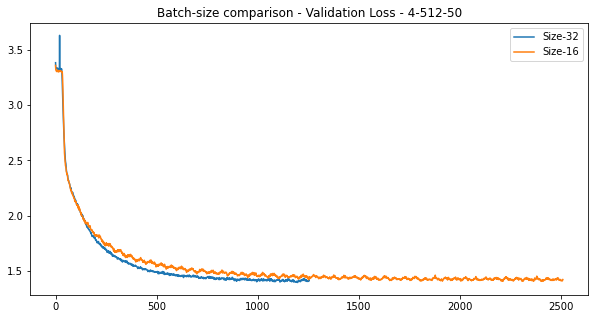

In [243]:
plt.figure(figsize=(10, 5))
plt.title('Batch-size comparison - Validation Loss - 4-512-50')
plt.plot(loss_32,label = 'Size-32')
plt.plot(loss_16,label = 'Size-16')
plt.legend()
plt.show()

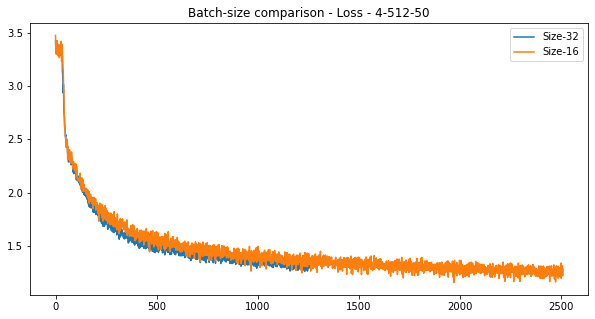

In [244]:
plt.figure(figsize=(10, 5))
plt.title('Batch-size comparison - Loss - 4-512-50')
plt.plot(val_loss_32,label = 'Size-32')
plt.plot(val_loss_16,label = 'Size-16')
plt.legend()
plt.show()

In [232]:
model_shakespeare_tragedias = 'rnn_50_epoch_4-512_batch-32.net'

checkpoint = {'n_hidden': net_2.n_hidden,
              'n_layers': net_2.n_layers,
              'state_dict': net_2.state_dict(),
              'tokens': net_2.chars}

with open(model_shakespeare_tragedias, 'wb') as f:
    torch.save(checkpoint, f)



In [233]:
def predict(net, char, h=None, top_k=None):
    ''' Given a character, predict the next character.
        Returns the predicted character and the hidden state.
    '''

    # tensor inputs
    x = np.array([[net.char2int[char]]])
    x = one_hot_encode(x, len(net.chars))
    inputs = torch.from_numpy(x)

    if(train_on_gpu):
        inputs = inputs.cuda()

    # detach hidden state from history
    h = tuple([each.data for each in h])
    # get the output of the model
    out, h = net(inputs, h)

    # get the character probabilities
    # apply softmax to get p probabilities for the likely next character giving x
    p = F.softmax(out, dim=1).data
    if(train_on_gpu):
        p = p.cpu() # move to cpu

    # get top characters
    # considering the k most probable characters with topk method
    if top_k is None:
        top_ch = np.arange(len(net.chars))
    else:
        p, top_ch = p.topk(top_k)
        top_ch = top_ch.numpy().squeeze()

    # select the likely next character with some element of randomness
    p = p.numpy().squeeze()
    char = np.random.choice(top_ch, p=p/p.sum())

    # return the encoded value of the predicted char and the hidden state
    return net.int2char[char], h

In [234]:
def sample(net, size, prime='PRIMER ACTO', top_k=None):

    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()

    net.eval() # eval mode

    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)

    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

In [245]:
print(sample(net_2, 5000, top_k=5))

PRIMER ACTO


ESCENA I

Entra AARÓN y la SEÑORA CAPULETO.

CAFPO: ¿Están secretos de su propio poco.

HORACIO: ¿Pero está muerto?

MACBETH: ¿Quién?

SATURNINO: ¡Ah, esto es la muerte! Ah, no hasta ellos.

Sale .

ESCENA II

En el dolor .

EDMOND: Nobelleza, aquí en la tierra de su pensamiento.
El amor de las dignidades que en el mandaen el mantador como el ama al caso
que no el duque y su promesa de lo que en el castillo
es eso primo que es un confiado. Esos sueños deben
hablar a las mesas de sus cinturas y mantienen
a mi corazón para que no hay descertes
a mi sumada para que se escapara a mi poco.

Entra CLEOPATRA.

SIRVIENTE: DE TITO ¡Casa es con eso encortarte!

Entra un MENSAJERO.

ROMEO: ¡Si te he visto a la verdad, para que estoy solo?
¿Qué pretendes de la tierra es la persona?

MARCIO: ¿No hay mi amante es un caballero?

EDMOND: ¿Qué te hablas, ahora, me harían ahora a la parte?
MÚDIAR SEGUNDO Sus casas son estos cielos,
que solo has dado sobre su propia cara,
que no es peligros